In [2]:
import tensorflow as tf
import time

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.33)

In [3]:
import tarfile
import re
import urllib.request
import os
import random

class ImdbMovieReviews:
    DEFAULT_URL = \
        'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
    TOKEN_REGEX = re.compile(r'[A-Za-z]+|[!?.:,()]')
    
    def __init__(self):
        self._cache_dir = './imdb'
        self._url = 'http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
        
        if not os.path.isfile(self._cache_dir):
            print('not')
            urllib.request.urlretrieve(self._url, self._cache_dir)
        self.filepath = self._cache_dir

    def __iter__(self):
        with tarfile.open(self.filepath) as archive:
            items = archive.getnames()
            for filename in archive.getnames():
                if filename.startswith('aclImdb/train/pos/'):
                    yield self._read(archive, filename), True
                elif filename.startswith('aclImdb/train/neg/'):
                    yield self._read(archive, filename), False
                    
    def _read(self, archive, filename):
        with archive.extractfile(filename) as file_:
            data = file_.read().decode('utf-8')
            data = type(self).TOKEN_REGEX.findall(data)
            data = [x.lower() for x in data]
            return data

In [4]:
import numpy as np
# Spacy is my favourite nlp framework, which havu builtin word embeddings trains on wikipesia
from spacy.en import English

class Embedding:
    
    def __init__(self):
#          spaCy makes using word vectors very easy. 
#             The Lexeme , Token , Span  and Doc  classes all have a .vector property,
#             which is a 1-dimensional numpy array of 32-bit floats:
        self.parser = English()
#         self._length = length
        self.dimensions = 300
        
    def __call__(self, sequence, length):
        # DO I really need them to be equal length?
        # Let's assume I'm not
        data = np.zeros((length, self.dimensions))
        # you can access known words from the parser's vocabulary
        embedded = [self.parser.vocab[w].vector for w in sequence]
        data[:len(sequence)] = embedded
        return data

In [5]:
import itertools

def preprocess_batched_split(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch = []
        labelss = []
        sentence_sizes_batch = []
        for index in range(batch_size):
            text, label = next(iterator)
            sents = [list(y) for x, y in itertools.groupby(text, lambda z: z == '.') if not x]
            sentence_sizes = [len(s) for s in sents]
            text_embed = [embedding(sent) for sent in sents]
            
            batch.append(text_embed)
            labelss.append(label)
            sentence_sizes_batch.append(sentence_sizes)
            
        labels_batch = np.array(labelss, dtype=np.int32)
        sent_per_doc = np.array([len(x) for x in sentence_sizes_batch])
        words_per_sent_per_doc = np.array(sentence_sizes_batch)
        yield np.array(batch), labels_batch, words_per_sent_per_doc, sent_per_doc

In [6]:
import itertools

def preprocess_batched_split2(iterator, embedding, batch_size):
    iterator = iter(iterator)
    while True:
        batch, labels_b = zip(*itertools.islice(iterator, batch_size))
        
        sents_b = [[list(y) for x, y in itertools.groupby(doc, lambda z: z == '.') if not x] for doc in batch]

        sentence_sizes_b = [[len(sent) for sent in doc] for doc in sents_b]
        sentence_size = max(map(max, sentence_sizes_b))
        
        document_sizes = np.array([len(doc) for doc in sentence_sizes_b], dtype=np.int32)
        document_size = document_sizes.max()

        sentence_sizes_np = np.zeros(shape=[batch_size, document_size], dtype=np.int32)
        for bi, ds, ss in zip(range(sentence_sizes_np.shape[0]), document_sizes, sentence_sizes_b):
            sentence_sizes_np[bi][:ds] = ss
        
        text_embed_b = np.zeros((batch_size, document_size, sentence_size, 300))
        for i, ds, doc_sents in zip(range(text_embed_b.shape[0]), document_sizes, sents_b):
            doc_sents_embed = np.array([embedding(sent, sentence_size) for sent in doc_sents])
            text_embed_b[i][:ds] = doc_sents_embed
        
        yield text_embed_b, np.array(labels_b, dtype=np.int32), np.array(document_sizes), sentence_sizes_np, sents_b

In [7]:
reviews = list(ImdbMovieReviews())

In [8]:
random.shuffle(reviews)

In [11]:
#################################################

In [12]:
import HanSequenceLabellingModel
import model_components

In [13]:
%reload_ext autoreload

In [14]:
%load_ext autoreload
%autoreload 1
#%aimport HanSequenceLabellingModel, model_components
%aimport

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Modules to reload:


Modules to skip:



In [20]:
batch_size = 10

In [15]:
batches_split = preprocess_batched_split2(reviews, Embedding(), batch_size=batch_size)

In [16]:
from HanSequenceLabellingModel import HanSequenceLabellingModel

In [17]:
def HAN_model_1(session, restore_only=False):
    """Hierarhical Attention Network"""
    import tensorflow as tf
    try:
        from tensorflow.contrib.rnn import GRUCell, MultiRNNCell, DropoutWrapper
    except ImportError:
        MultiRNNCell = tf.nn.rnn_cell.MultiRNNCell
        GRUCell = tf.nn.rnn_cell.GRUCell
    from bn_lstm import BNLSTMCell
    from HanSequenceLabellingModel import HanSequenceLabellingModel

    is_training = tf.placeholder(dtype=tf.bool, name='is_training')

    cell = BNLSTMCell(80, is_training) # h-h batchnorm LSTMCell
    cell = MultiRNNCell([cell]*5)

    model = HanSequenceLabellingModel(
            embedding_size=300,
            classes=2,
            word_cell=cell,
            sentence_cell=cell,
            word_output_size=300,
            sentence_output_size=300,
            learning_rate=0.001,
            max_grad_norm=5.0,
            dropout_keep_proba=0.5,
            is_training=is_training,
    )

    saver = tf.train.Saver(tf.global_variables())
    checkpoint_dir = 'checkpoints'
    checkpoint = tf.train.get_checkpoint_state(checkpoint_dir)
    if checkpoint:
        print("Reading model parameters from %s" % checkpoint.model_checkpoint_path)
        saver.restore(session, checkpoint.model_checkpoint_path)
    elif restore_only:
        raise FileNotFoundError("Cannot restore model")
    else:
        print("Created model with fresh parameters")
        session.run(tf.global_variables_initializer())
        
    return model, saver

## Visualize attention for IMDB reviews on both sentence and word level (10 points)

In [15]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())
    
    data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch = next(batches_split)

    fd = {
        model.is_training: True,
        model.inputs_embedded: data,
        model.word_lengths: words_per_sent_per_doc,
        model.sentence_lengths: sent_per_doc,
        model.labels: labels_batch,
        model.sample_weights: np.ones(shape=(10))
    }

    sentence_attention_weights,  word_attention_weights = s.run([model.sentence_attention_weights,
                                                                 model.word_attention_weights],
                                                                feed_dict=fd)

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400


In [16]:
sent_per_doc

array([12, 10,  8,  8, 14,  9,  8, 15,  9, 27], dtype=int32)

In [188]:
words_per_sent = sents_batch[9]

In [256]:
sent_weights = sentence_attention_weights[9] / np.max(sentence_attention_weights[9]) - np.min(sentence_attention_weights[9])

In [257]:
word_weights_per_sent = []

max_w = -1
min_w = 1

for i in range(len(words_per_sent)):
    word_weights_per_sent.append([])
    cur_weights = word_attention_weights[-len(words_per_sent) +i]    
    for j in range(len(words_per_sent[i])):
        word_weights_per_sent[-1].append(cur_weights[j][0])
        max_w = max(max_w, cur_weights[j][0])
        min_w = min(min_w, cur_weights[j][0])
    
    
for i in range(len(words_per_sent)):
    for j in range(len(words_per_sent[i])):
        word_weights_per_sent[i][j] /= max_w
        word_weights_per_sent[i][j] -= min_w

In [280]:
import colorsys

def rgb2hex(colors):
    return '#%02x%02x%02x' % colors

def float_rgb2int_rgb(colors):
    return tuple(int(x * 255) for x in colors)
    
def red2hex(saturation):
    return rgb2hex(float_rgb2int_rgb(colorsys.hsv_to_rgb(0, 1, 1)))
    
def blue2hex(saturation):
    return rgb2hex(float_rgb2int_rgb(colorsys.hsv_to_rgb(0.65, 1, 1)))

In [389]:
from IPython.display import HTML as html_print

def colored_str(s, color='white'):
    return "<font size='3'><text style=background-color:{}>{}</text></font>".format(color, s)

def sentence(weight_sentence, words, weights):
    return colored_str('&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;', red2hex(weight_sentence)) + '&nbsp;&nbsp;' + '&nbsp;&nbsp;'.join([colored_str(word, blue2hex(weight))
                                                                            for word, weight in zip(words, weights)])

In [390]:
def print_several(rows):
    ans = '<table cellspacing="0" cellpadding="0"> '
    for r in rows:
        ans += '<tr style="background-color:white"><td style="text-align:left">' + r + '</td></tr>'
    ans += '</table>'
    return ans

In [391]:
sents = [sentence(i, j, k) for i, j, k in zip(sent_weights, words_per_sent, word_weights_per_sent)]

In [392]:
sents = sorted(sents)

In [393]:
 html_print(print_several(sents))

when one thinks of s science fiction films one thinks of the sort of schlocky black and white b films that were parodied on the old mystery science theater television show
forbidden planet is one of those rare films that both defines yet transcends its era unlike other sci fi films which were rather obvious cold war allegories
"br br it s worth knowing that , despite forbidden planet s happy ending , there is the possibility that the moti is still dormant within alta , as well"
"only such films like : a space odyssey , solaris , alien and aliens , and the first two terminator films , have really equaled or surpassed this classic in depth and effects"
"watch it , and you will agree , as well as sleep a little less easy"
"the film also makes good use of narrative ellipses to condense the tale , something that far more realistic art films often fail to do"
"it s not a perfect film , but it s a great way to spend a couple of hours , and far better than star wars , which although made twenty years later seems much more outdated , and juvenile"
"also , the film wisely only shows the moti once , and never shows the krel , for the imagination can always conjure greater scares than the best special effects"
that alone is timeless
as for the main feature ? forbidden planet deserves all its kudos
"but , even if you don t , there s still the scene of anne francis skinnydipping"


## Plot attention weight distribution of words "good" and "bad" for both positive and negative reviews and compare them (6 points)

In [ ]:
w = {"good": {0: [], 1: []}, "bad": {0: [], 1: []}}

tf.reset_default_graph()
config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)

    for iter_num, (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split):

        if iter_num % 100 == 0:
            print("step", iter_num)
        
        fd = {
            model.is_training: False,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        sentence_attention_weights, word_attention_weights = s.run([model.sentence_attention_weights,  
                                                                     model.word_attention_weights],
                                                                    feed_dict=fd)
        
        for i in range(len(sents_batch)):
            ans = labels_batch[i]
            for j in range(len(sents_batch[i])):
                for k in range(len(sents_batch[i][j])):
                    word = sents_batch[i][j][k]
                    if word == 'good' or word == 'bad':
                        cur_w = word_attention_weights[i * sentence_attention_weights.shape[1]][k].tolist()
                        w[word][ans].append(cur_w[0])
                        
        #print(w)
        max_num = 1000
        if (len(w["good"][0]) >= max_num and len(w["bad"][0]) >= max_num \
        and len(w["good"][1]) >= max_num and len(w["bad"][1]) >= max_num) or iter_num == 1000:
            break

In [395]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings; warnings.simplefilter('ignore')

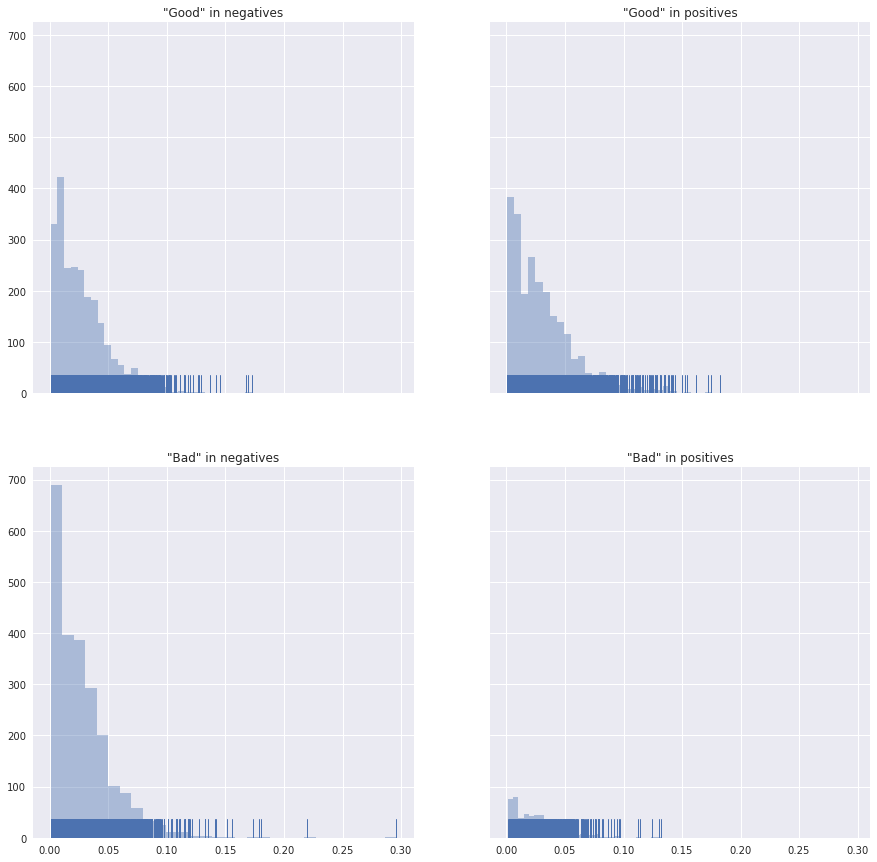

In [396]:
fig, ax = plt.subplots(figsize=(15,15), ncols=2, nrows=2, sharex=True, sharey=True)

sns.distplot(w["good"][0], bins=30, kde=False, rug=True, ax=ax[0][0]).set_title('"Good" in negatives');
sns.distplot(w["good"][1], bins=30, kde=False, rug=True, ax=ax[0][1]).set_title('"Good" in positives');
sns.distplot(w["bad"][0], bins=30, kde=False, rug=True, ax=ax[1][0]).set_title('"Bad" in negatives');
sns.distplot(w["bad"][1], bins=30, kde=False, rug=True, ax=ax[1][1]).set_title('"Bad" in positives');

## Compare accuracy for HAN with plain rnn-based 
Pre-trained model for comparation could be found in the classwork

In [53]:
tf.reset_default_graph()

config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)

TP = 0
all_pred = 0
steps = 100

with tf.Session(config=config) as s:
    model, saver = HAN_model_1(s)
    tflog_dir = 'tf_logs'
    summary_writer = tf.summary.FileWriter(tflog_dir, graph=tf.get_default_graph())

    for step_num, \
    (data, labels_batch, sent_per_doc, words_per_sent_per_doc, sents_batch) in enumerate(batches_split, 1):

        fd = {
            model.is_training: True,
            model.inputs_embedded: data,
            model.word_lengths: words_per_sent_per_doc,
            model.sentence_lengths: sent_per_doc,
            model.labels: labels_batch,
            model.sample_weights: np.ones(shape=(10))
        }

        prediction = s.run(model.prediction, feed_dict=fd)
        
        TP += (labels_batch == prediction).sum()
        all_pred += len(labels_batch)
        
        print(step_num, end='_')
        
        if step_num == steps:
            break

Reading model parameters from checkpoints/checkpoint-2400
INFO:tensorflow:Restoring parameters from checkpoints/checkpoint-2400
1_2_3_4_5_6_7_8_9_10_11_12_13_14_15_16_17_18_19_20_21_22_23_24_25_26_27_28_29_30_31_32_33_34_35_36_37_38_39_40_41_42_43_44_45_46_47_48_49_50_51_52_53_54_55_56_57_58_59_60_61_62_63_64_65_66_67_68_69_70_71_72_73_74_75_76_77_78_79_80_81_82_83_84_85_86_87_88_89_90_91_92_93_94_95_96_97_98_99_100_

In [54]:
print("HAN accuracy:", TP / all_pred)

HAN accuracy: 0.834
